In [ ]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [ ]:
import shutil
import tempfile
import zipfile
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from anomalib.config import get_configurable_parameters
from anomalib.data import get_datamodule
from anomalib.data.inference import InferenceDataset
from anomalib.models import get_model
from anomalib.post_processing.post_process import compute_mask
from anomalib.utils.callbacks import LoadModelCallback, get_callbacks
from anomalib.utils.loggers import configure_logger, get_experiment_logger
from pytorch_lightning import Trainer, seed_everything
from skimage.morphology import dilation
from skimage.segmentation import find_boundaries
from torch.utils.data import DataLoader


/home/toon/anomalib-demo/.venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Settings

In [ ]:
idrid_zip_location = '/home/toon/Downloads/B. Disease Grading.zip'
data_folder = Path('../data')

patchcore_config_path = 'cfg/patchcore_config.yaml'
patchcore_output_dir = Path('../models')

## Data preparation

The IDRiD dataset consists of 3 parts (segmentation, disease grading and localization), which can be downloaded from https://ieee-dataport.org/open-access/indian-diabetic-retinopathy-image-dataset-idrid (after registration). In this notebook we will only use 'B. Disease Grading.zip'. We copy all images of healthy retina to data_folder/idrid/normal, these will be used to train the model. We also copy a small sample of images of retina with signs of diabetic retinopathy, which will be used to test the model.

In [ ]:
with tempfile.TemporaryDirectory() as tmp_data_dir:
    with zipfile.ZipFile(idrid_zip_location, 'r') as idrid_zip_ref:
        idrid_zip_ref.extractall(tmp_data_dir)

        tmp_data_dir = Path(tmp_data_dir)
        gt_path = tmp_data_dir / 'B. Disease Grading' / '2. Groundtruths'
        original_img_path = tmp_data_dir / 'B. Disease Grading' / '1. Original Images'

        normal_img_dst = data_folder / 'idrid' / 'normal'
        normal_img_dst.mkdir(exist_ok=True, parents=True)

        dr_img_dst = data_folder / 'idrid' / 'dr'
        dr_img_dst.mkdir(exist_ok=True, parents=True)

        for csv_fn, dir_name in [('a. IDRiD_Disease Grading_Training Labels.csv', 'a. Training Set'), ('b. IDRiD_Disease Grading_Testing Labels.csv', 'b. Testing Set')]:
            gt_csv = pd.read_csv(gt_path / csv_fn)

            no_retinopathy = gt_csv[gt_csv['Retinopathy grade'] == 0]
            for _, no_retinopathy_img in no_retinopathy.iterrows():
                shutil.copy(original_img_path / dir_name/ (no_retinopathy_img['Image name'] + '.jpg'), normal_img_dst / f"{dir_name.strip()}_{no_retinopathy_img['Image name']}.jpg")
            
            for retinopathy_grade in range(1,5):
                cur_dst = dr_img_dst / str(retinopathy_grade)
                cur_dst.mkdir(exist_ok=True, parents=True)

                retinopathy_subset = gt_csv[gt_csv['Retinopathy grade'] == retinopathy_grade]
                for _, retinopathy_img in retinopathy_subset.iterrows(): 
                    shutil.copy(original_img_path / dir_name/ (retinopathy_img['Image name'] + '.jpg'), cur_dst / f"{dir_name.strip()}_{retinopathy_img['Image name']}.jpg")

## Model training

In [ ]:
config = get_configurable_parameters(model_name='patchcore', config_path=patchcore_config_path)
if config.project.seed:
    seed_everything(config.project.seed)

datamodule = get_datamodule(config)
model = get_model(config)
experiment_logger = get_experiment_logger(config)
callbacks = get_callbacks(config)

Transform configs has not been provided. Images will be normalized using ImageNet statistics.
Transform configs has not been provided. Images will be normalized using ImageNet statistics.


In [ ]:
trainer = Trainer(**config.trainer, logger=experiment_logger, callbacks=callbacks)
trainer.fit(model=model, datamodule=datamodule)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_predict_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
/home/toon/anomalib-demo/.venv/lib/python3.8/site-packages/anomalib/data/folder.py:216: UserWarning: Segmentation task is requested, but mask directory is not provided. Classification is to be chosen if mask directory is not provided.
  warnings.warn(
/home/toon/anomalib-demo/.venv/lib/python3.8/site-packages/anomalib/data/folder.py:216: UserWarning: Segmentation task is requested, 

Epoch 0:  17%|█▋        | 1/6 [00:26<02:13, 26.69s/it, loss=nan]

/home/toon/anomalib-demo/.venv/lib/python3.8/site-packages/pytorch_lightning/loops/optimization/optimizer_loop.py:137: UserWarning: `training_step` returned `None`. If this was on purpose, ignore this warning...
  self.warning_cache.warn("`training_step` returned `None`. If this was on purpose, ignore this warning...")


Epoch 0:  83%|████████▎ | 5/6 [01:18<00:15, 15.62s/it, loss=nan]

/home/toon/anomalib-demo/.venv/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:726: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


## Evaluate on some images showing signs of diabetic retinopathy

In [ ]:
def get_prediction(img_path, model_config_path, model_weight_path):
    config = get_configurable_parameters(config_path=model_config_path)
    config.trainer.resume_from_checkpoint = model_weight_path
    config.visualization.show_images = False
    config.visualization.save_images = False

    model = get_model(config)
    callbacks = get_callbacks(config)

    trainer = Trainer(callbacks=callbacks, **config.trainer)
    transform_config = config.dataset.transform_config.val if "transform_config" in config.dataset.keys() else None

    dataset = InferenceDataset(
       img_path, image_size=tuple(config.dataset.image_size), transform_config=transform_config
    )
    dataloader = DataLoader(dataset)
    
    return trainer.predict(model=model, dataloaders=[dataloader])


def add_boundary(image, anomaly_map, threshold=0.5, thickness=20, color=(255, 0, 0)):
     marked = np.copy(image)
     anomaly_mask = compute_mask(anomaly_map, threshold)
     boundaries = find_boundaries(anomaly_mask)
     outlines = dilation(boundaries, np.ones((thickness, thickness)))
     image[outlines] = color
     return image

def plot_prediction(img_path, model_result):
    img = cv2.imread(img_path)[:,:,::-1] # BGR to RGB
    anomaly_map = np.squeeze(model_result[0]['anomaly_maps'].numpy())
    anomaly_map_original_size = cv2.resize(anomaly_map, (img.shape[1], img.shape[0]))
    segmentation_boundary = add_boundary(img, anomaly_map_original_size, threshold=0.3)
    
    plt.figure(figsize=(20,10))
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.axis('off')
    plt.imshow(anomaly_map_original_size, alpha=0.5)
    plt.subplot(1,2,2)
    plt.imshow(segmentation_boundary)
    plt.axis('off')
    plt.show()
        

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_predict_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
Transform configs has not been provided. Images will be normalized using ImageNet statistics.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


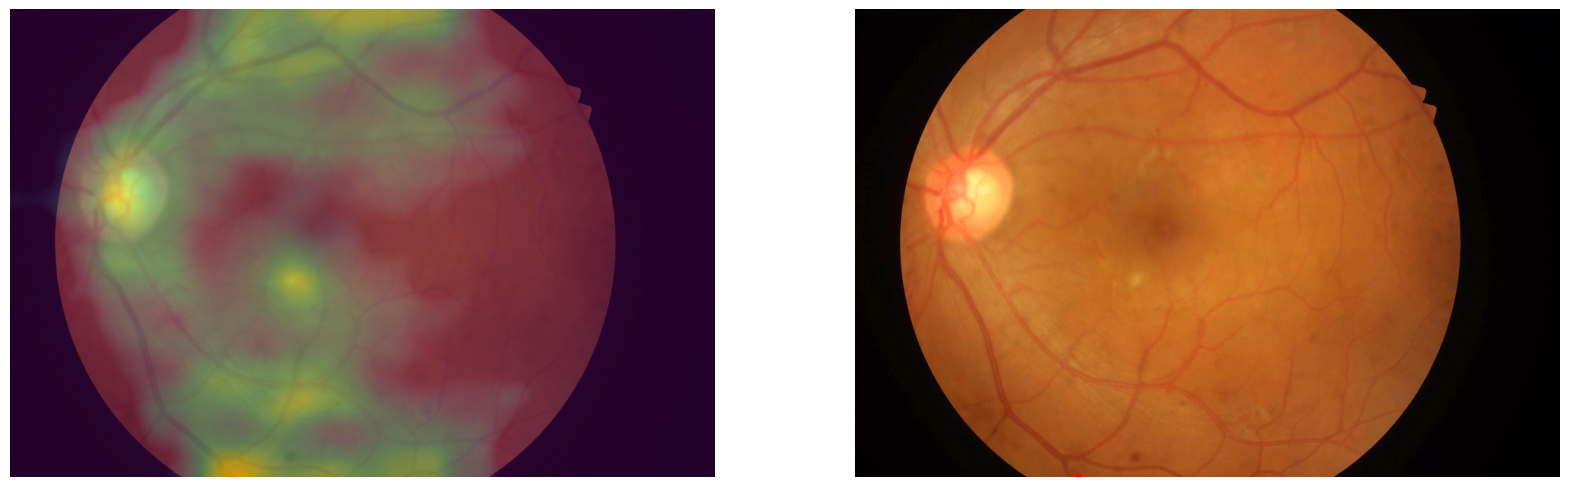

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_predict_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
Transform configs has not been provided. Images will be normalized using ImageNet statistics.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


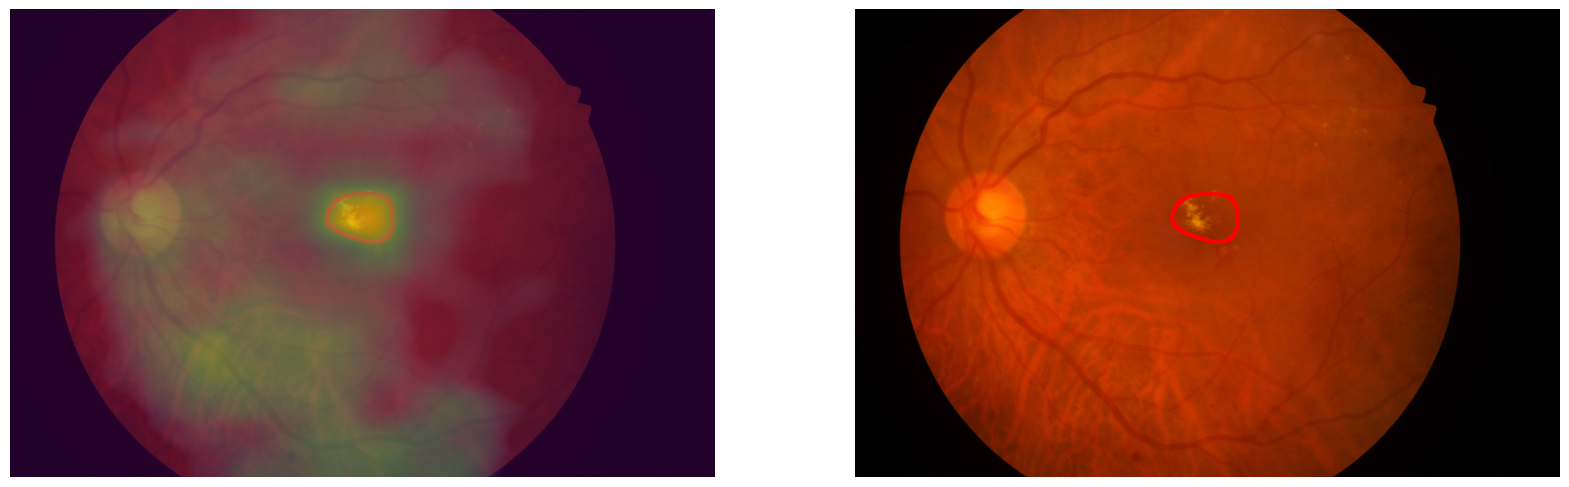

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_predict_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
Transform configs has not been provided. Images will be normalized using ImageNet statistics.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


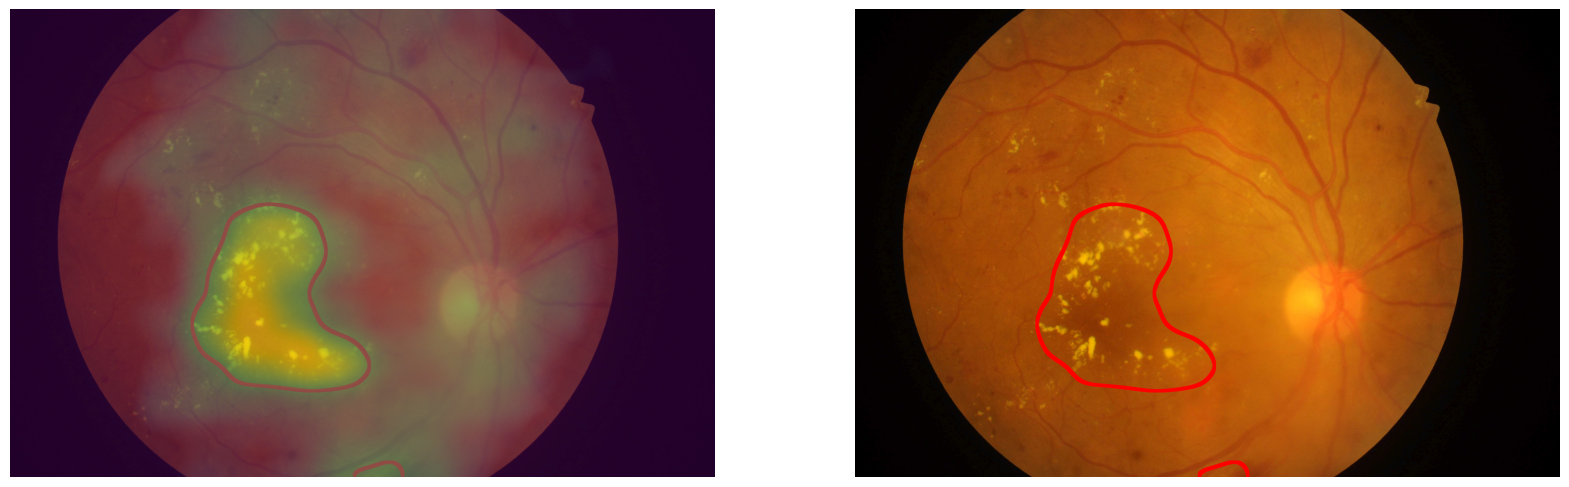

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_predict_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
Transform configs has not been provided. Images will be normalized using ImageNet statistics.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:01<00:00,  1.41s/it]


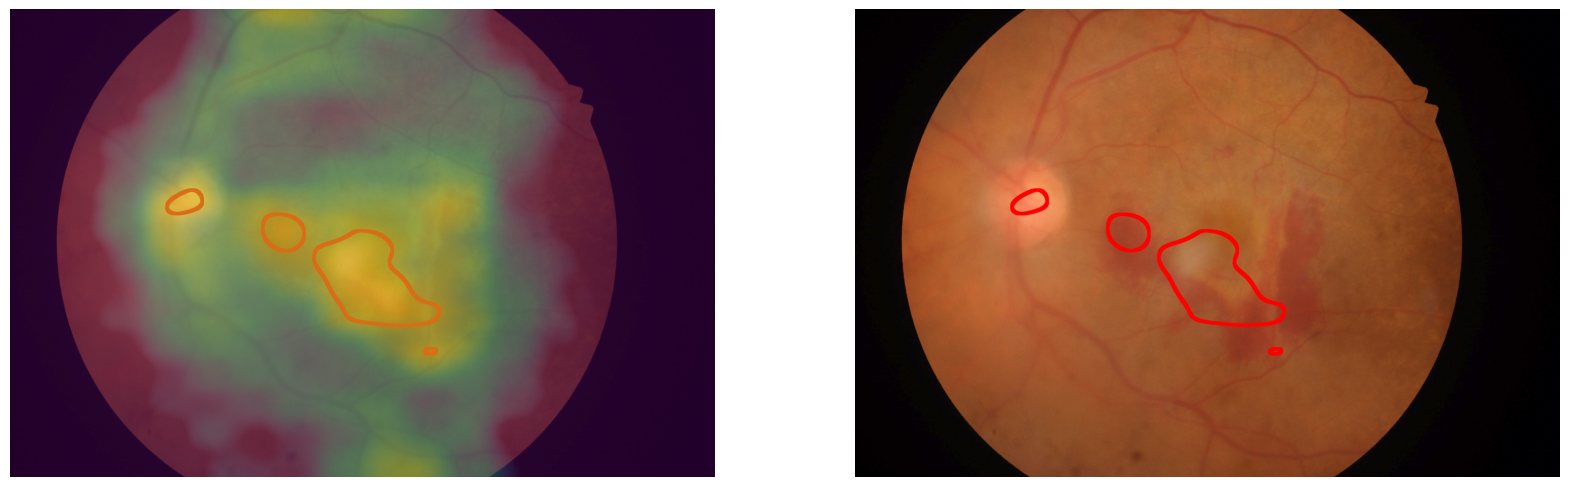

In [ ]:
for grade in range(1,5):
    img_path = sorted((data_folder / 'idrid' / 'dr' / str(grade)).glob('*.jpg'))[0].as_posix()
    model_weight_path = patchcore_output_dir / 'patchcore' / 'idrid' / 'weights' / 'model.ckpt'
    pred = get_prediction(img_path, patchcore_config_path, model_weight_path)
    plot_prediction(img_path, pred)

/home/toon/anomalib-demo/.venv/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/toon/anomalib-demo/.venv/lib/python3.8/site-packages/anomalib/utils/callbacks/__init__.py:143: UserWarning: Export option: None not found. Defaulting to no model export
  warnings.warn(f"Export option: {config.optimization.export_mode} not found. Defaulting to no model export")
/home/toon/anomalib-demo/.venv/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:51: LightningDeprecationWarning: Setting `Trainer(resume_from_checkpoint=)` is deprecated in v1.5 and will be removed in v1.7. Please pass `Trainer.fit(ckpt_path=)` directly instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/toon/anomalib-demo/.venv/lib/python3.8/site-packages/anomalib/models/patchcore/torch_model.py:182: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  weights = (1 - F.softmax(distances.squeeze()))[..., 0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it]
